In [1]:
## Imports
import os
import random
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Options
pd.set_option('max_colwidth', None)
random.seed(42)

In [2]:
path = "/content/drive/MyDrive/DS Job Tasks/Safe_Sign_Task/task_folder"

def createPath(dir):
  return os.path.join(path, dir)

def map_inputs(input):
  for key in input.keys():
    if key != "index":
      return input[key]

### Load the raw sample data

In [3]:
raw_data_sample_path = os.path.join(path, 'raw_data_sample.json')
sample_data = pd.read_json(raw_data_sample_path)
print(sample_data.shape)

(9777, 7)


In [4]:
# Extract the question from inputs column
sample_data['questions'] = sample_data['inputs'].map(lambda input: map_inputs(input))

In [5]:
sample_data.head(1)

,index,raw_dataset_id,answer,inputs,prompt_template,prompt,task,questions
0,0,51,suggestive,"{'index': '51', 'text': 'The mark ""Equine Technologies"" for horse hoof pads.'}","A mark is generic if it is the common name for the product. A mark is descriptive if it describes a purpose, nature, or attribute of the product. A mark is suggestive if it suggests or implies a quality or characteristic of the product. A mark is arbitrary if it is a real English word that has no relation to the product. A mark is fanciful if it is an invented word.\n\nQ: The mark ""Ivory"" for a product made of elephant tusks. What is the type of mark?\nA: generic\n\nQ: The mark ""Tasty"" for bread. What is the type of mark?\nA: descriptive\n\nQ: The mark ""Caress"" for body soap. What is the type of mark?\nA: suggestive\n\nQ: The mark ""Virgin"" for wireless communications. What is the type of mark?\nA: arbitrary\n\nQ: The mark ""Aswelly"" for a taxi service. What is the type of mark?\nA: fanciful\n\nQ: {{text}} What is the type of mark?\nA:","A mark is generic if it is the common name for the product. A mark is descriptive if it describes a purpose, nature, or attribute of the product. A mark is suggestive if it suggests or implies a quality or characteristic of the product. A mark is arbitrary if it is a real English word that has no relation to the product. A mark is fanciful if it is an invented word.\n\nQ: The mark ""Ivory"" for a product made of elephant tusks. What is the type of mark?\nA: generic\n\nQ: The mark ""Tasty"" for bread. What is the type of mark?\nA: descriptive\n\nQ: The mark ""Caress"" for body soap. What is the type of mark?\nA: suggestive\n\nQ: The mark ""Virgin"" for wireless communications. What is the type of mark?\nA: arbitrary\n\nQ: The mark ""Aswelly"" for a taxi service. What is the type of mark?\nA: fanciful\n\nQ: The mark ""Equine Technologies"" for horse hoof pads. What is the type of mark?\nA:",abercrombie,"The mark ""Equine Technologies"" for horse hoof pads."


### How many tasks do we have?

- In total we have 161 tasks under the legalbench dataset.
- Some of these tasks have more data available than others.
- Dataset contains more tasks with fewer data and very few tasks with very high amount of data available for those tasks.

In [6]:
unique_tasks = sample_data['task'].value_counts()
print(f"Number of tasks: {len(unique_tasks)}\n")
unique_tasks[:10]

Number of tasks: 161



privacy_policy_qa                        546
international_citizenship_questions      465
learned_hands_housing                    224
privacy_policy_entailment                216
unfair_tos                               190
overruling                               119
learned_hands_family                     113
opp115_first_party_collection_use        104
opp115_third_party_sharing_collection     79
opp115_user_choice_control                77
Name: task, dtype: int64

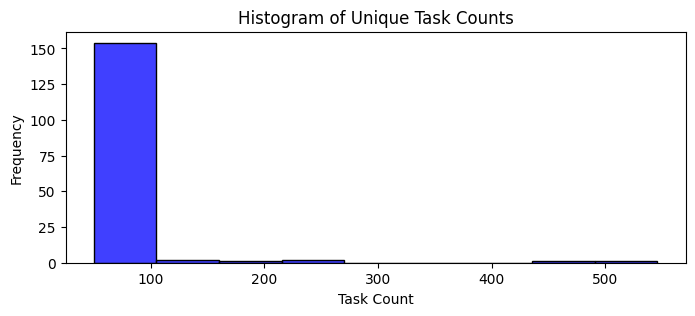

In [7]:
import matplotlib.pyplot as plt
task_counts = sample_data['task'].value_counts()

plt.figure(figsize=(8,3))
sns.histplot(task_counts, color="blue")
plt.title('Histogram of Unique Task Counts')
plt.xlabel('Task Count')
plt.ylabel('Frequency')
plt.show()

### How many different answers are present?

- We have in total of 307 unique responses present in the dataset.
- Most of the responses from the prompts are categorical with lesser than 10 categories.
- Highest number of questions have Yes/No response.

In [8]:
unique_answers = sample_data['answer'].value_counts()
print("Number of different answers", len(unique_answers), "\n")
unique_answers[:10]

Number of different answers 307 



No            3232
Yes           3131
B              773
A              556
Irrelevant     280
Relevant       266
C              205
Correct        190
Other          170
D              140
Name: answer, dtype: int64

In [9]:
### Some sample questions
sample_data[['questions', 'answer']][:10]

,questions,answer
0,"The mark ""Equine Technologies"" for horse hoof pads.",suggestive
1,"The mark ""Lanbe"" for custom wallets.",fanciful
2,"The mark ""Cutlery"" for eating utencils.",generic
3,"The mark ""Shark"" for a custom t-shirt maker.",arbitrary
4,"The mark ""Sun"" for computers.",arbitrary
5,"The mark ""Trim"" for nail clippers.",descriptive
6,"The mark ""Moodle"" for an internet search engine.",fanciful
7,"The mark ""Imprion"" for a line of sports drinks.",fanciful
8,"The mark ""TidePool"" for treehouse manufacturing company.",arbitrary
9,"The mark ""TidePool"" for treehouse manufacturing company.",arbitrary


### How many of these tasks can be categorized as classification tasks?

In [10]:
unique_answers_per_category = {}
classiying_tasks = []

for category in sample_data['task'].unique():
  category_data = sample_data[sample_data['task'] == category]
  unique_answers_per_category[category] = category_data['answer'].unique()

# Print the unique answers for each category
for category, answers in unique_answers_per_category.items():
  if len(answers)<10:
    classiying_tasks.append(category)

print(f"Number of classification tasks: {len(classiying_tasks)}")

Number of classification tasks: 155


### Word count of prompts and questions per task

- The word count can be considered high for each tasks and extreme in some cases.
- For many of the tasks the wordcount varies from as few as 50 to 2k-5k words in the prompt
- Same applies for questions, questions are shorted than prompts but the count ranges from 500 to 5k words

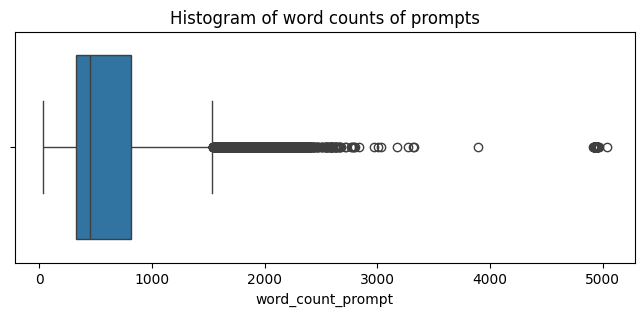

In [11]:
sample_data['word_count_prompt'] = sample_data['prompt'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8,3))
plt.title("Histogram of word counts of prompts")
sns.boxplot(data=sample_data, x='word_count_prompt');

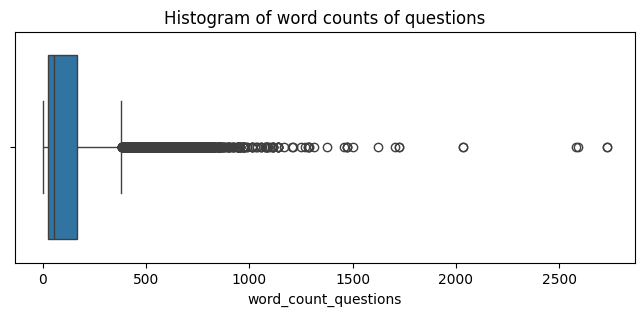

In [12]:
sample_data['word_count_questions'] = sample_data['questions'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8,3))
plt.title("Histogram of word counts of questions")
sns.boxplot(data=sample_data, x='word_count_questions');

In [13]:
sample_data['word_count_prompt'] = sample_data['prompt'].apply(lambda x: len(x.split()))
sample_data.groupby('task')['word_count_prompt'].describe()

,count,mean,std,min,25%,50%,75%,max
task,,,,,,,,
abercrombie,50.0,165.780000,1.741334,164.0,165.00,165.0,166.75,172.0
canada_tax_court_outcomes,50.0,165.020000,101.800423,82.0,107.00,124.0,164.00,445.0
citation_prediction_classification,50.0,162.960000,10.480224,146.0,155.25,163.5,171.00,182.0
citation_prediction_open,50.0,139.180000,13.006576,122.0,128.00,137.0,148.00,171.0
consumer_contracts_qa,50.0,472.640000,230.808142,130.0,310.00,371.0,623.00,1005.0
...,...,...,...,...,...,...,...,...
telemarketing_sales_rule,50.0,289.260000,12.193692,269.0,279.00,289.0,298.00,317.0
textualism_tool_dictionaries,50.0,951.040000,69.098557,853.0,908.00,947.0,981.50,1156.0
textualism_tool_plain,50.0,734.120000,89.708062,603.0,670.00,715.5,783.00,1075.0


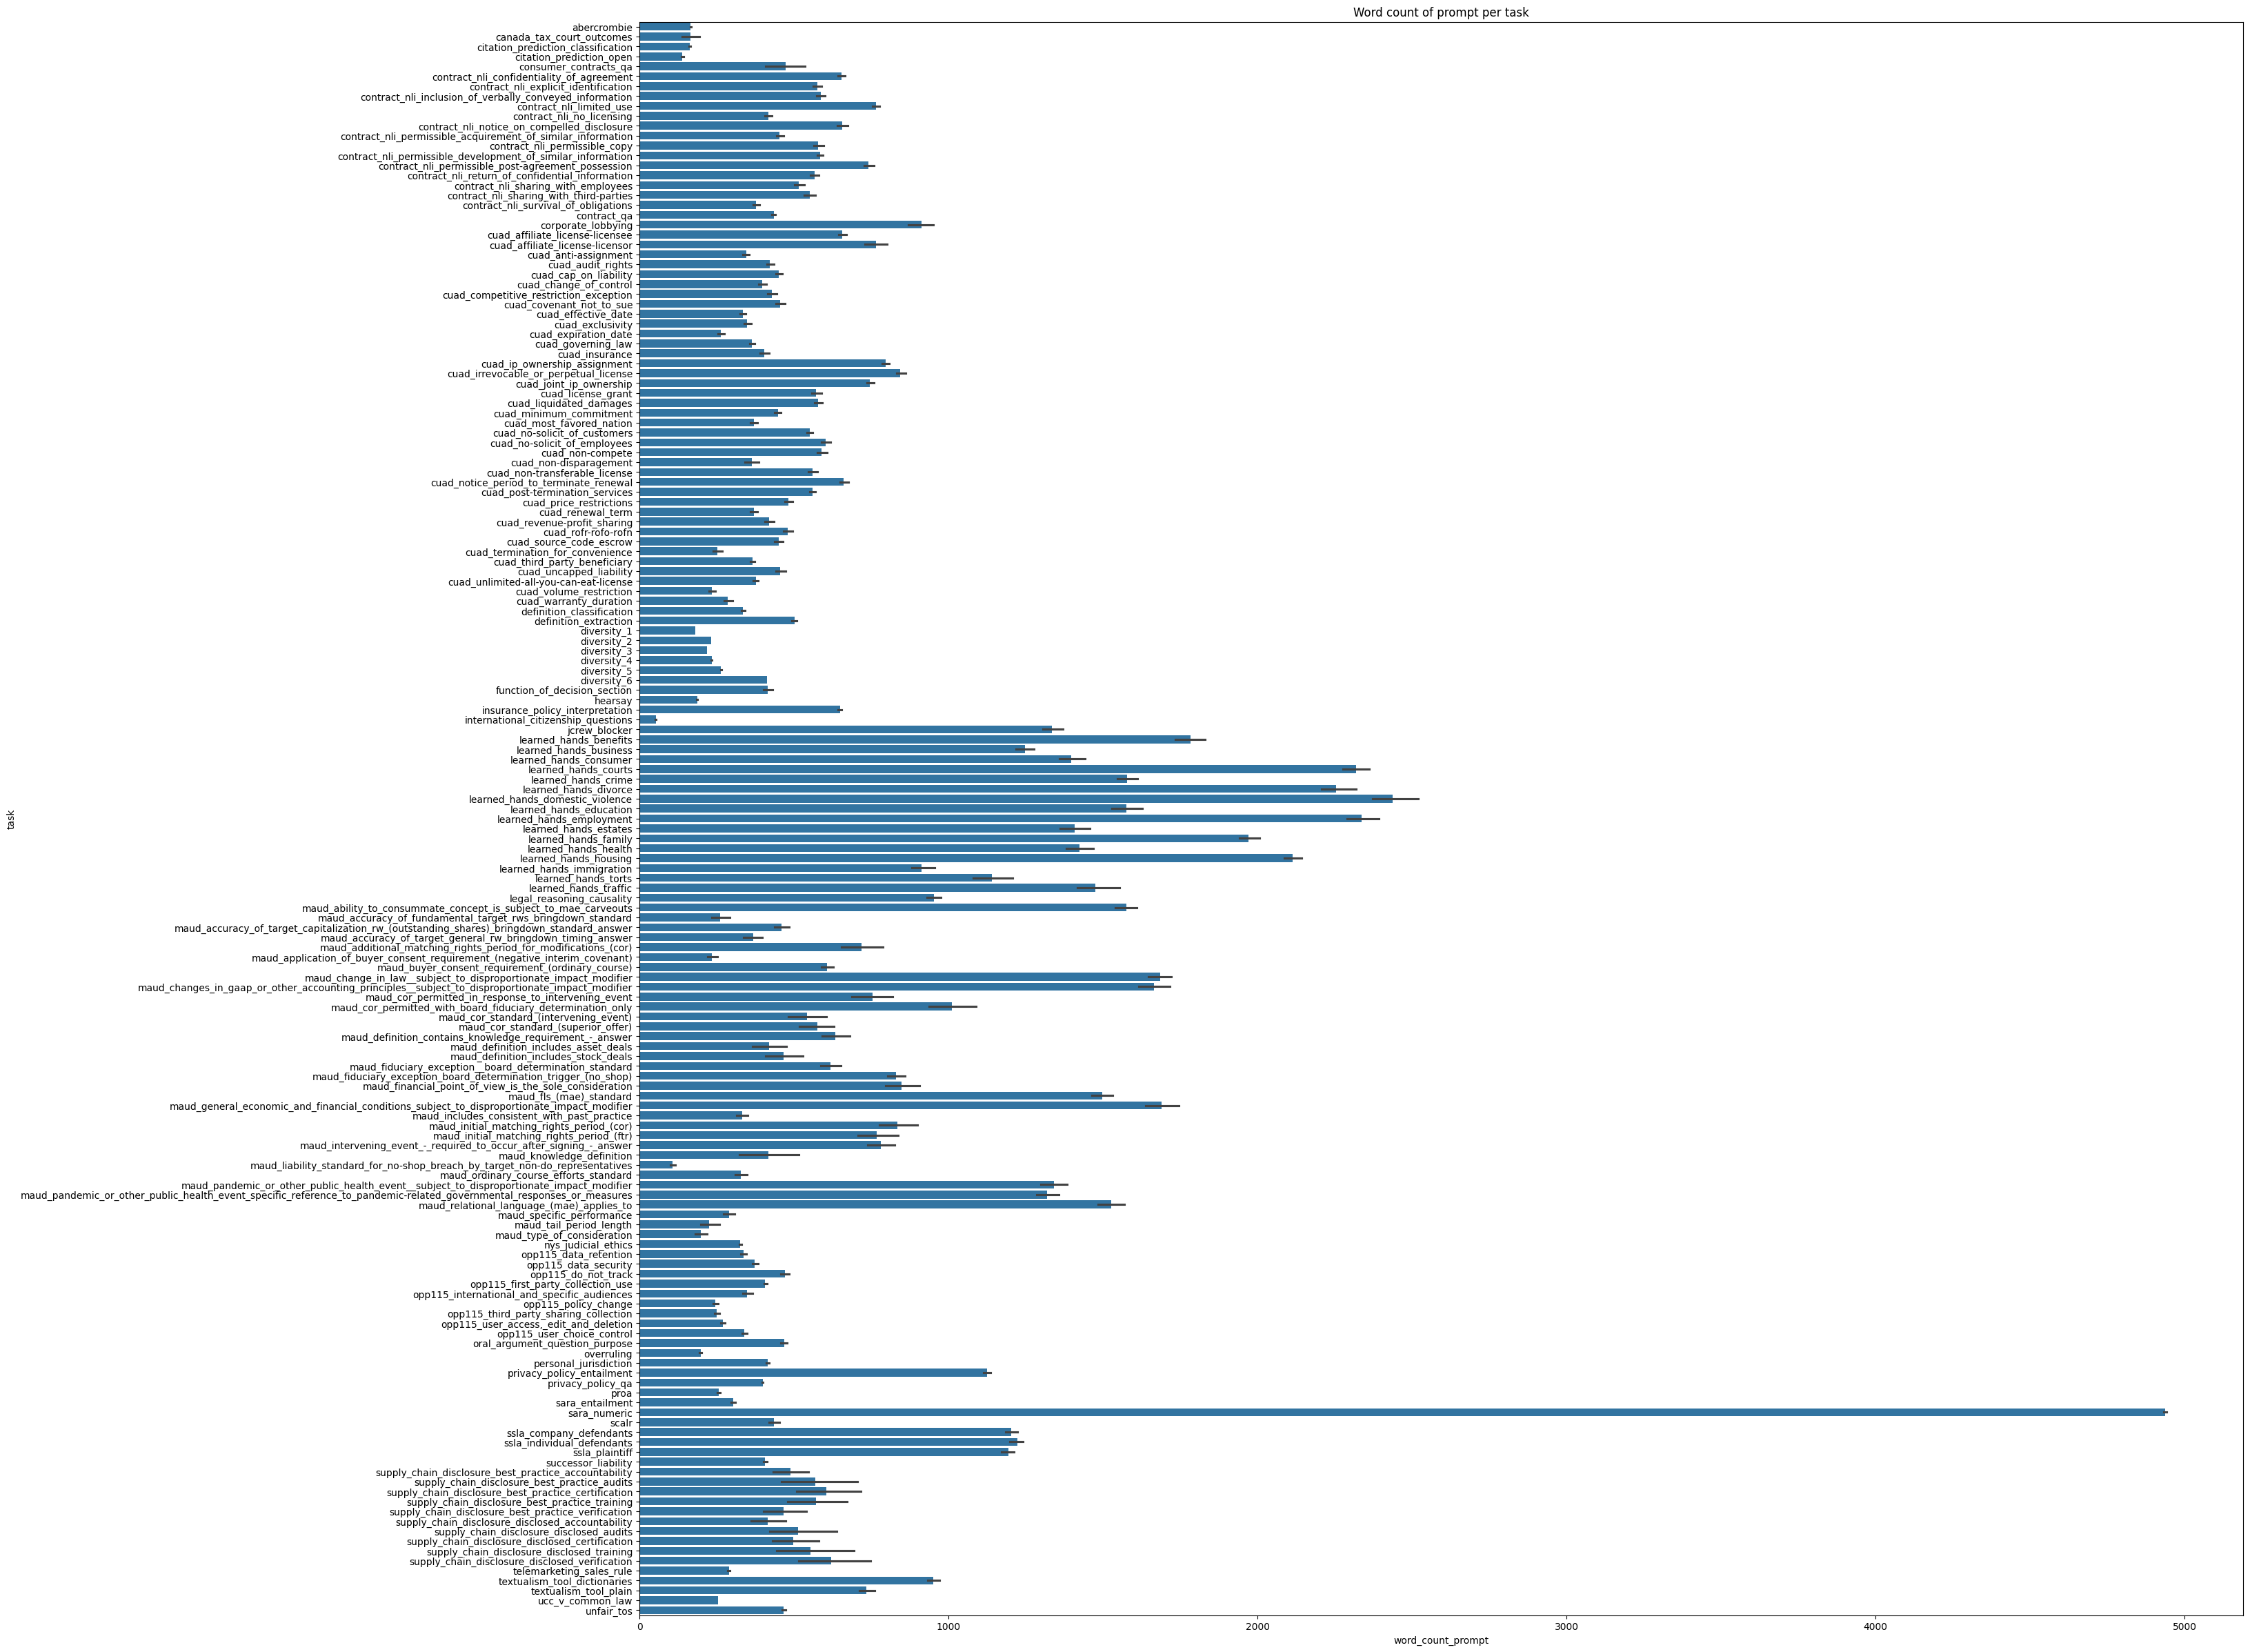

In [14]:
plt.figure(figsize=(30,30))
plt.title("Word count of prompt per task")
sns.barplot(y='task', x='word_count_prompt', data=sample_data);

### Lets look at a specific prompt `consumer_contracts_qa `

- Most of these contracts aer pretty long contracts and have a binary response for the questions
- Although the answer to the question isn't explicitly mentioned in the prompt but is implicit if you read the entire contract.

In [15]:
prompt = "consumer_contracts_qa"
prompt_path = os.path.join(path, "prompts", prompt, "train.tsv")
prompt_data = pd.read_csv(prompt_path, sep='\t')
print(prompt_data.shape)
prompt_data

(4, 4)


,index,contract,question,answer
0,0,"Licence\nYour content remains yours, which means that you retain any intellectual property rights that you have in your content. For example, you have intellectual property rights in the creative content that you make, such as reviews that you write. Or you may have the right to share someone elses creative content if theyve given you their permission.\nWe need your permission if your intellectual property rights restrict our use of your content. You provide Google with that permission through this licence.\n\nWhat's covered\nThis licence covers your content if that content is protected by intellectual property rights.\n\nWhats not covered\nThis licence doesnt affect your privacy rights its only about your intellectual property rights\nThis licence doesnt cover these types of content:\npublicly available, factual information that you provide, such as corrections to the address of a local business. That information doesnt require a licence because its considered common knowledge that everyones free to use.\nfeedback that you offer, such as suggestions to improve our services. Feedback is covered in the Service-related communications section below.\n\nScope\nThis licence is:\nworldwide, which means that its valid anywhere in the world\nnon-exclusive, which means that you can license your content to others\nroyalty-free, which means that there are no fees for this licence\n\nRights\nThis licence allows Google to:\nhost, reproduce, distribute, communicate and use your content for example, to save your content on our systems and make it accessible from anywhere that you go\npublish, publicly perform or publicly display your content, if youve made it visible to others\nmodify and create derivative works based on your content, such as reformatting or translating it\nsublicense these rights to:\nother users to allow the services to work as designed, such as enabling you to share photos with people that you choose\nour contractors whove signed agreements with us that are consistent with these terms, only for the limited purposes described in the Purpose section below\n\nPurpose\nThis licence is for the limited purpose of:\noperating and improving the services, which means allowing the services to work as designed and creating new features and functionalities. This includes using automated systems and algorithms to analyse your content:\nfor spam, malware and illegal content\nto recognise patterns in data, such as determining when to suggest a new album in Google Photos to keep related photos together\nto customise our services for you, such as providing recommendations and personalised search results, content and ads (which you can change or turn off in Ads Settings)\nThis analysis occurs as the content is sent, received and when it is stored.\nusing content that youve shared publicly to promote the services. For example, to promote a Google app, we might quote a review that you wrote. Or to promote Google Play, we might show a screenshot of the app that you offer in the Play Store.\ndeveloping new technologies and services for Google consistent with these terms\n\nDuration\nThis licence lasts for as long as your content is protected by intellectual property rights.\nIf you remove from our services any content thats covered by this licence, our systems will stop making that content publicly available in a reasonable amount of time. There are two exceptions:\nIf you already shared your content with others before removing it. For example, if you shared a photo with a friend who then made a copy of it, or shared it again, then that photo may continue to appear in your friends Google Account even after you remove it from your Google Account.\nIf you make your content available through other companies' services, its possible that search engines, including Google Search, will continue to find and display your content as part of their search results.",Is Google allowed to create new content based on the co

#### How much data do we have for this prompt


In [16]:
consumer_contract_qa = sample_data[sample_data['task']==prompt]
print(consumer_contract_qa.shape)

(50, 10)


#### Some import keywords in consumer contracts

- We can see terms like content, payment, service, term, use, right, product, account which are common among contract terminologies.

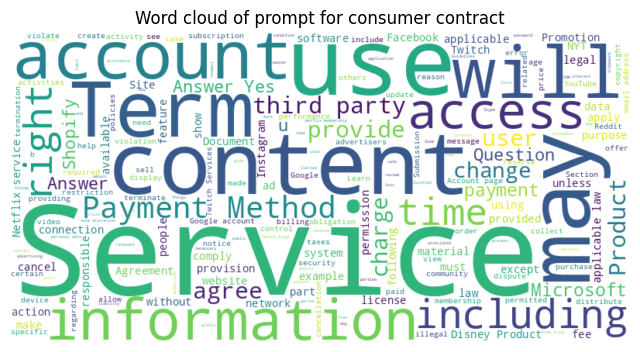

In [17]:
text = ' '.join(consumer_contract_qa['prompt'])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(8, 5))
plt.title("Word cloud of prompt for consumer contract")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


### How many terms from the question appear in the prompt?

In [28]:
def count_common_terms(row):
  prompt_words = set(row['prompt'].split())
  question_words = set(row['questions'].split())
  return len(prompt_words.intersection(question_words))/(len(question_words))

sample_data['common_terms'] = sample_data.apply(count_common_terms, axis=1)
print(sample_data['common_terms'].describe())


count    9777.000000
mean        0.938284
std         0.235640
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: common_terms, dtype: float64


### How much is the percentage overlap between question and the prompt

In [25]:
num_common_terms = sample_data['common_terms'].sum()
total_terms = sample_data['prompt'].str.split().str.len().sum() + sample_data['questions'].str.split().str.len().sum()

percentage_overlap = num_common_terms / total_terms * 100

print(f"Percentage overlap between questions and prompts: {percentage_overlap:.2f}%")


Percentage overlap between questions and prompts: 9.46%
